In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch import nn
import os

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


# DNN Architecture

In [156]:
def apply_kernels(input_image, kernels1, kernels2=None):
    out = input_image.clone()
    out2 = None
    for k in kernels1:
        out = F.conv2d(out, k, padding='same', stride=1)  
    if kernels2 is not None:
        out2 = input_image.clone()
        for k in kernels2:
            out2 = F.conv2d(out2, k, padding='same', stride=1)
        out = out*out2
    return out,out2

def predict(input_image, kernels1, kernels2=None):
    input_image = torch.tensor(input_image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    with torch.no_grad():
        output_image,_ = apply_kernels(input_image, kernels1, kernels2)
        output_image *= 255.0
    return output_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

def generate_kernels(Nk1,Nk2=None):
    K1 = [torch.rand(3, 3, 5, 5, requires_grad=True)]
    if Nk2 is not None:
        K2 = [torch.rand(3, 3, 3, 3, requires_grad=True)]
        return K1,K2
    return K1

def train_model(input_images, target_images, target_edges, kernels1=None, kernels2=None, Nk1=1, Nk2=1 , epochs=10, lr=0.01):
    oimg = input_images.copy()
    L = []
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]  
    target_edges = [img / 255.0 for img in target_edges]  
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])  
    target_edges = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_edges]) 
    # Initialize kernels
    if kernels1 is None:
        kernels1 = generate_kernels(Nk1)
    if kernels2 is None and Nk2 is not None:
        kernels2 = generate_kernels(Nk2)
    # Define optimizer
    if kernels2 is not None:
        optimizer = optim.Adam(kernels1 + kernels2, lr=lr)
    else: 
        optimizer = optim.Adam(kernels1, lr=lr)
    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        for input_image, target_image, ed, o in zip(input_images, target_images, target_edges,oimg):
            cv2.imshow("Predicted", np.clip(predict(o, kernels1, kernels2), 0, 255))  # Display Image
            input_image = input_image.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension
            target_image = target_image.permute(2, 0, 1).unsqueeze(0) 
            ed = ed.permute(2, 0, 1).unsqueeze(0) 
            optimizer.zero_grad()   
            output_image,edges = apply_kernels(input_image, kernels1, kernels2)
            if kernels2 is None:
                    loss = F.mse_loss(output_image,target_image)
            else:
                loss = F.mse_loss(output_image,target_image)#+0.2*F.mse_loss(edges,ed)
            loss.backward()
            optimizer.step()          
            total_loss += loss.item() 
            cv2.waitKey(10)
        L.append(total_loss/len(input_images))
        clear_output()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(input_images):.8f}')
        if len(L) > 2:
            print('+',abs(L[-2]-L[-1])) if L[-1]>L[-2] else print('-',abs(L[-1]-L[-2]))
         #   if abs(L[-2] - L[-1]) < 1e-6:
          #      break
    print('Training complete.')
    cv2.destroyAllWindows()
    return kernels1, kernels2, L

In [138]:
def read_first_10_frames_from_videos(directory,N):
    video_frames = []  # Dictionary to store video names and their first 10 frames
    for filename in os.listdir(directory):
        if filename.endswith(".mp4"):  # Check for video file extensions
            video_path = os.path.join(directory, filename)
            cap = cv2.VideoCapture(video_path)
            frames = []
            frame_count = 0
            while frame_count < N and cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break  # If the video ends before 10 frames
                frames.append(frame)
                frame_count += 1
            cap.release()  # Release the video capture object
            video_frames += frames  # Store the frames with the video name
    return video_frames

In [62]:
def save_kernels(kernels1, kernels2, file_path):
    torch.save({'kernels1': kernels1, 'kernels2': kernels2}, file_path)
    print(f'Kernels saved to {file_path}')
def load_kernels(file_path):
    checkpoint = torch.load(file_path)
    kernels1 = checkpoint['kernels1']
    kernels2 = checkpoint['kernels2']
    print(f'Kernels loaded from {file_path}')
    return kernels1, kernels2

In [190]:
directory_path = 'Uncartoonized/'
org = read_first_10_frames_from_videos(directory_path,40)
#ThroughFrames(orgs)

In [191]:
directory_path = 'Cartoonized/'
cart = read_first_10_frames_from_videos(directory_path,40)
#ThroughFrames(carts)

In [192]:
edges = [canny_edge(k,inverted=False) for k in org]

In [193]:
org = [cv2.resize(o,(640,320)) for o in org]
cart = [cv2.resize(o,(640,320)) for o in cart]
edges = [cv2.resize(o,(640,320)) for o in edges]

In [194]:
len(org)

259

In [195]:
edges =  [np.stack((e,e,e),axis=2) for e in edges]

In [196]:
edges[0].shape,org[0].shape

((320, 640, 3), (320, 640, 3))

In [197]:
kernels1, kernels2, Losses = train_model(org, cart,edges, kernels1,kernels2,Nk1=10, Nk2=10,epochs=20, lr=1e-7)

Epoch [20/20], Loss: 0.020401
- 1.3824746472948513e-07
Training complete.


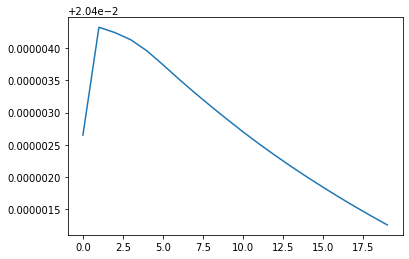

In [198]:
plt.plot(Losses)

In [199]:
save_kernels(kernels1, kernels2, 'trained_kernels10.pth')
kernels1, kernels2 = load_kernels('trained_kernels10.pth')

Kernels saved to trained_kernels10.pth
Kernels loaded from trained_kernels10.pth


In [203]:
Predicted = [predict(o,kernels1,kernels2) for o in org]

In [204]:
ThroughFrames(Predicted)

In [207]:
save_vid(Predicted,"Predicted/org_pred10.mp4",20)

In [211]:
cap0 = open_vid("VDB/bunny.mp4")
org0 = get_frames(cap0)
h,w,fps,c = get_props(cap0)

Width:  640
Height:  360
FPS:  30.0
Frame Count:  852


In [212]:
Predicted0 = [predict(o,kernels1,kernels2) for o in org0]

In [213]:
ThroughFrames(Predicted0)

In [214]:
save_vid(Predicted0,"Predicted/bunny_pred10.mp4",fps)

In [215]:
Predict1 = [predict(o,kernels1) for o in org0]

In [217]:
ThroughFrames(Predict1)

In [219]:
save_vid(Predict1,"Predicted/bunny_pred10_1.mp4",fps)

In [220]:
Predict2 = [predict(o,kernels2) for o in org0]

In [ ]:
ThroughFrames(Predict2)

In [221]:
save_vid(Predict2,"Predicted/bunny_pred10_2.mp4",fps)

In [ ]:
## Apply kernels over filtered image
## Border detector and Smoother
## Different kernel sizes
## Border detector small
## Smoother larger
## Check what happens if a kernel is omited
## Use past and future frames
## Formalize the problem
## What's the main objective of project?
## Other DNN structures: GAN, Graphic Transformer